In [1]:
#Colab read data from google drive
import os
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/MyDrive/Pornpan(Eye)')

Mounted at /content/drive/


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Products

🎯 Our goal is to find `product categories` that repeatedly `underperform` vs. others, and understand the reasons behind.

## 1 - Code `olist/product.py` 

🎁 We gave you the solution to `product.py` in your challenge folder

👉 `product.py` provides you with aggregated data for each `product_id` sold on Olist.

----
The `get_training_data` method in `olist/product.py` returns a DataFrame with the following features:

| feature_name                 	| type  	| description                                                               	|
|:------------------------------	|:-------:	|:---------------------------------------------------------------------------	|
| `product_id`                 	| str   	| id of the product **UNIQUE**                                              	|
| `category`                   	| str   	| category name (in English)                                                	|
| `product_name_length`        	| float 	| number of characters of a product name                                    	|
| `product_description_length` 	| float 	| number of characters of a product description                             	|
| `product_photos_qty`         	| int   	| number of photos available for a product                                  	|
| `product_weight_g`           	| float 	| weight of the product                                                     	|
| `product_length_cm`          	| float 	| length of the product                                                     	|
| `product_height_cm`          	| float 	| height of the product                                                     	|
| `product_width_cm`           	| float 	| width of the product                                                      	|
| `price`                      	| float 	| average price at which the product is sold                                	|
| `wait_time`                  	| float 	| average wait time (in days) for orders in which the product was sold      	|
| `share_of_five_stars`        	| float 	| share of five-star review_scores for orders in which the product was sold 	|
| `share_of_one_stars`         	| float 	| share of one-star review_scores for orders in which the product was sold  	|
| `review_score`               	| float 	| average review score of the orders in which the product was sold          	|
| `n_orders`                   	| int   	| number of orders in which the product appears                             	|
| `quantity`                   	| int   	| total number of products sold for each product_id                         	|
| `sales`                      	| int   	| total sales (in BRL) for each product_id                                  	|

❓ **Take a first glimpse at the `product().get_training_data()` DataFrame** and make sure to understand what it represents, and how it has been coded

In [3]:
from olist.product import Product
products = Product().get_training_data()
products.head()

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,sales
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,3.017639,10.910000,0.0,1.0,5.0,1,1,10.91
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,10.275272,16.900000,0.0,0.5,3.5,2,2,33.80
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,13.933686,325.627273,0.2,0.4,3.7,10,11,3581.90
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery,21.219062,399.900000,0.0,0.0,2.0,1,1,399.90
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery,8.965984,137.900000,0.0,1.0,5.0,1,1,137.90


## 2 - Analysis per `product_id`

🎯 Can we predict the average `review_score` per `product_id` ? 

👉 We inspect for you the new `Product().get_training_data()` dataframe, for instance by `plotting histograms of each variable` using `plt.hist()`. 

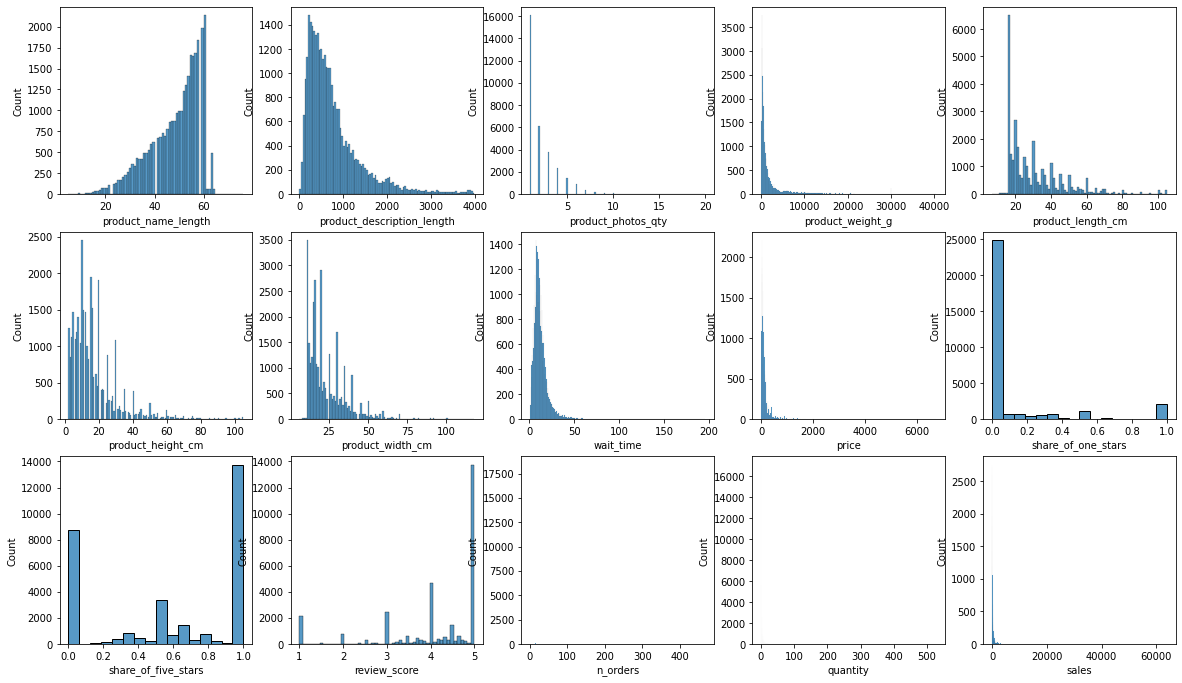

In [5]:
plt.figure(figsize=(20,20))
for (i, col) in enumerate(products.set_index('product_id').drop(columns='category').columns):
    plt.subplot(5,5,i+1)
    sns.histplot(products[col])

### (2.2) Predicting the  average `review_score` per `product_id`

🚀 Model `review_score` with an `OLS`.

👉  **Choose which continuous features you would like to use to predict the review score**

* What is the $R^2$ of your model ❓
* Among the feature you chose, which ones are the most important/significant ❓

In [6]:
# The volume of a product is easy to compute
# and it will probably play a role on the review score
# as a heavy object is harder to ship

products['product_volume_cm3'] = products["product_length_cm"] * products["product_height_cm"] * products["product_width_cm"]

In [7]:
# Defining our target
target = "review_score"

In [8]:
# What features do we have access to ? 
set(products.columns) - set(target)

{'category',
 'n_orders',
 'price',
 'product_description_length',
 'product_height_cm',
 'product_id',
 'product_length_cm',
 'product_name_length',
 'product_photos_qty',
 'product_volume_cm3',
 'product_weight_g',
 'product_width_cm',
 'quantity',
 'review_score',
 'sales',
 'share_of_five_stars',
 'share_of_one_stars',
 'wait_time'}

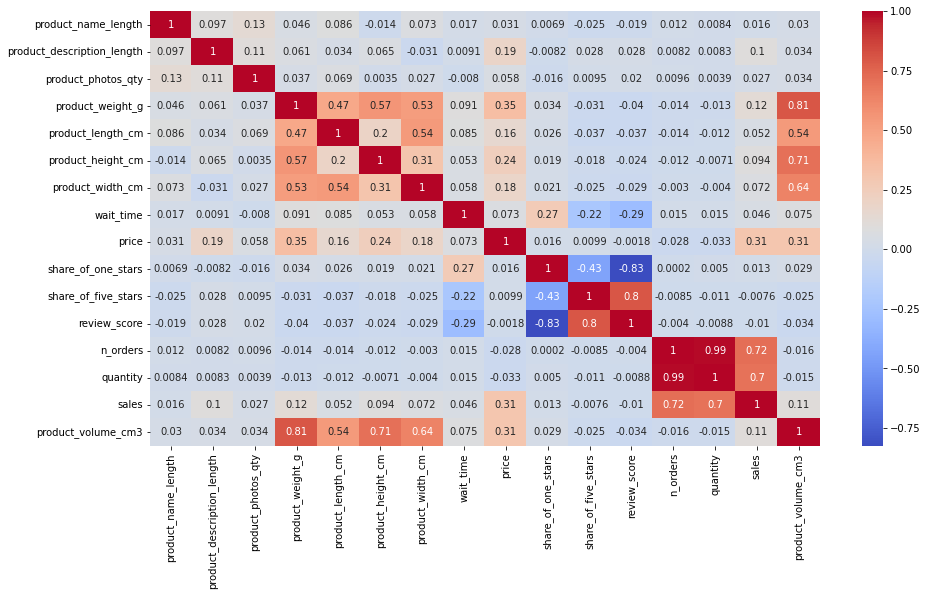

In [9]:
# How are the features linearly correlated ? 

plt.figure(figsize = (15,8))

sns.heatmap(products.corr(), 
            cmap='coolwarm', 
            annot = True, 
            annot_kws={"size": 10})

In [10]:
# Let's reprint the features we have access to:
set(products.columns) - set(target)

{'category',
 'n_orders',
 'price',
 'product_description_length',
 'product_height_cm',
 'product_id',
 'product_length_cm',
 'product_name_length',
 'product_photos_qty',
 'product_volume_cm3',
 'product_weight_g',
 'product_width_cm',
 'quantity',
 'review_score',
 'sales',
 'share_of_five_stars',
 'share_of_one_stars',
 'wait_time'}

💡 Some features seem interesting:
* `product_photos_qty` : the more pictures available, the more likely you will make the decision to purchase it
* `product_volume_cm3` : it is faster to ship a smartphone cable than a convertible sofa...
* `wait_time` : are Olist' customers patient ?
* `price` : how does the price of a product influence a customer's satisfaction ?
* `n_orders` : it might indicate whether a product is popular or not
* `quantity` : same thing

🤔 There may be some correlation between the quantity and the number of orders but let's run an OLS on these features now and see what outputs come out of it !

👇 **Your turn: run the OLS with features shown above**

In [11]:
products_selected_features = [
    'product_photos_qty',
    'product_volume_cm3',
    'wait_time',
    'price',
    'quantity',
    
]

Let's make sure that the selected features are not too correlated pairwise...

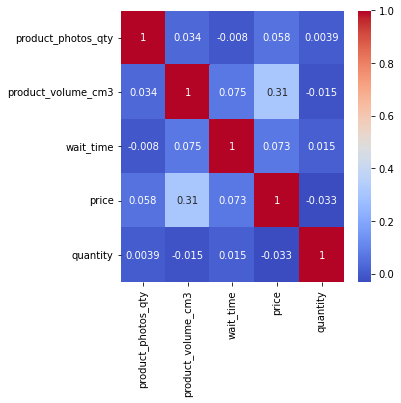

In [12]:
plt.figure(figsize = (5,5))

sns.heatmap(products[products_selected_features].corr(), 
            cmap='coolwarm', 
            annot = True, 
            annot_kws={"size": 10});

👉 Let's also not forget to **transform each feature $X_i$ into its respective z-score** $Z_i = \frac{X_i - \mu_i}{\sigma_i}$ in order to compare the partial regression coefficients $\beta_i$ together. Otherwise, the $\beta_i$ won't be in the same dimension, meaning you'll be comparing apples (e.g. "review_stars per day") with oranges (e.g. "review_stars per BRL")!

In [13]:
products_standardized = products.copy()
for f in products_selected_features:
    mu = products[f].mean()
    sigma = products[f].std()
    products_standardized[f] = products[f].map(lambda x: (x - mu) / sigma)
products_standardized[products_selected_features].head()

,product_photos_qty,product_volume_cm3,wait_time,price,quantity
0,-0.684384,-0.530169,-1.101806,-0.549566,-0.231049
1,-0.109395,-0.512988,-0.223766,-0.524959,-0.138354
2,-0.684384,-0.387941,0.218835,0.743302,0.695903
3,-0.109395,-0.473509,1.100232,1.048417,-0.231049
4,0.465594,-0.482735,-0.382166,-0.027887,-0.231049


In [14]:
formula = target + ' ~ ' + ' + '.join(products_selected_features)
formula

'review_score ~ product_photos_qty + product_volume_cm3 + wait_time + price + quantity'

In [15]:
import statsmodels.formula.api as smf

model = smf.ols(formula = formula, data = products_standardized).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     585.0
Date:                Wed, 24 Aug 2022   Prob (F-statistic):               0.00
Time:                        07:11:35   Log-Likelihood:                -47618.
No. Observations:               31481   AIC:                         9.525e+04
Df Residuals:                   31475   BIC:                         9.530e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.1101      0

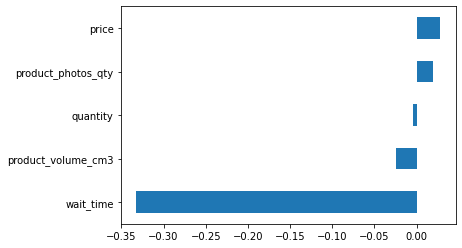

In [16]:
model.params[1:].sort_values().plot(kind='barh')

### (2.3) Some insights based on our OLS 👇:

<i><u>Note</u>: no questions in this section, it is dedicated to help you fully understand Linear Regressions and their interpretations</i>

🎉 Almost all the p-values are lower than 5%, which means than almost all our coefficients are statistically significant !

----

ℹ️ The price has a small positive impact on the review score. Is it a psychological effect when customers do not want to admit a product is bad because they paid a certain amount of money on it ?

----

😮 The number of photos is apparently less important than expected, even if there should be a minimum.

----

😮 The quantity has apparently no impact, notice the large p-value of its coefficient, on the review score of a product according to this model...

❗️ Let's not draw conclusions too quickly ❗️

* *Example 1*: for smartphones, it's extremely important that a charging cable does not break after a few weeks, so in general on e-commerce platforms, a good quality cable is ordered a thousand times and has a high average review score

* *Example 2* : for a product that belongs to a niche market, it can have a high average review score even if it was bought only a few times

🧑🏻‍🏫 The lesson here is that even if your coefficients are significant, a model represents some kind of guidance for your business-related decisions ! Please also use your common sense !

----

ℹ️ The product volume does not seem to have a big impact on the review score... but still the impact is slightly negative.

----

🔴 The `wait_time` has a huge negative impact on the review_score. Customers do not like to wait even though they already know some products are longer to ship than others !


## 3 - Analysis per `product category`

### (3.1) Which products are mainly sold on Olist ? 

In [17]:
products.category.nunique()

71

In [18]:
products_per_category = products.groupby("category")['product_id'].\
                                        count().\
                                        sort_values(ascending = False)
products_per_category = pd.DataFrame(products_per_category).reset_index()
products_per_category.columns = ["category", "nb_of_unique_products"]
top_20_products = products_per_category.head(20)
top_20_products

,category,nb_of_unique_products
0,bed_bath_table,2972
1,sports_leisure,2811
2,furniture_decor,2575
3,health_beauty,2390
4,housewares,2275
5,auto,1846
6,computers_accessories,1598
7,toys,1366
8,watches_gifts,1293
9,telephony,1104


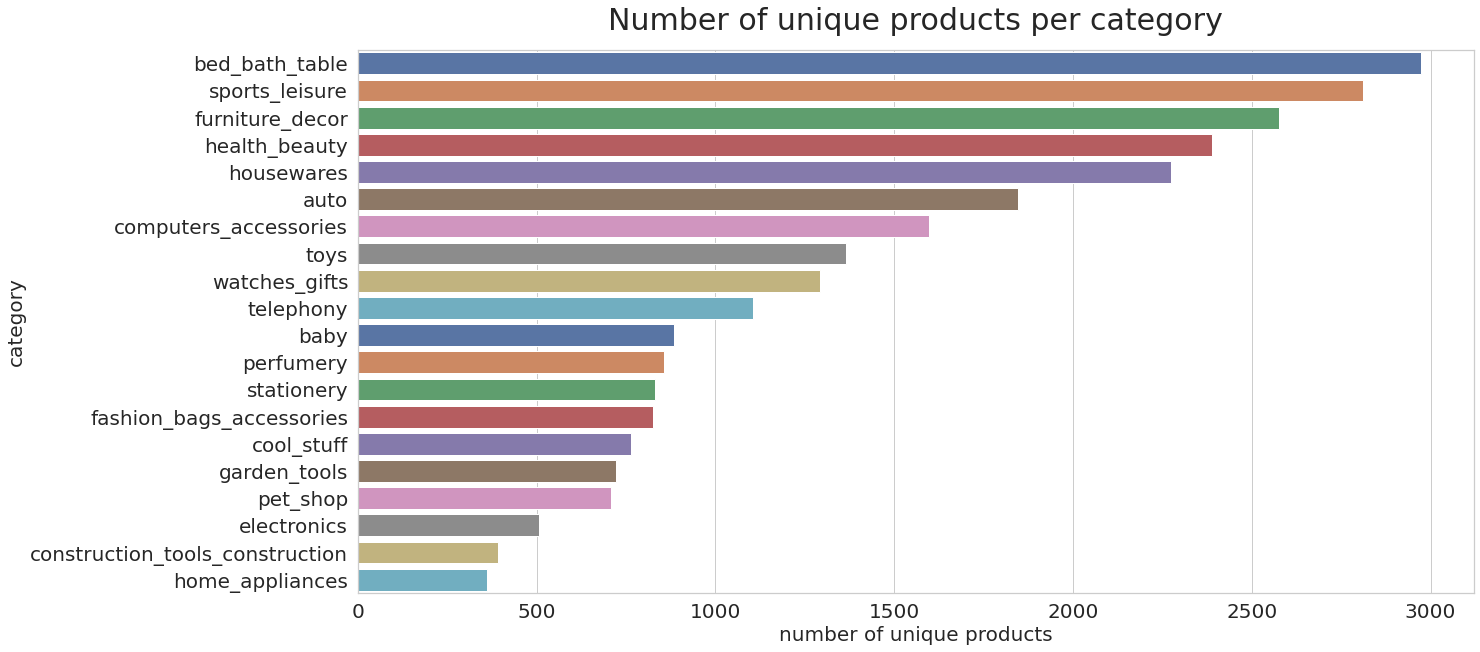

In [19]:
import seaborn as sns
sns.set_theme(style="whitegrid")

plt.figure(figsize = (20,10))

sns.barplot(y = top_20_products["category"],
            x = top_20_products["nb_of_unique_products"], 
            palette = "deep")

plt.title("Number of unique products per category", fontsize = 30, pad = 20)

plt.xlabel("number of unique products", fontsize = 20)
plt.ylabel("category", fontsize = 20)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);


### (3.2) Build an aggregated dataframe with a `get_product_cat` function.

👉 Create a function `get_product_cat` which:
* takes an `aggregating method as an argument` (choose the `mean` by default)
* returns a DataFrame with:
    * each `product_category`'s `quantity` summed 
    * all other numerical features aggregated by the chosen method.  


    For instance get_product_cat('median') returns:

      - `quantity` (sum)
      - `wait_time` (median)
      - `review_score` (median)
      - `price` (median)
      - ....

In [20]:
def get_product_cat(agg="median"):
    # $CHALLENGIFY_BEGIN
    columns = list(products.select_dtypes(exclude=['object']).columns)
    agg_params = dict(zip(columns, [agg] * len(columns)))
    agg_params['quantity'] = 'sum'

    return products.groupby("category").agg(agg_params)
    # $CHALLENGIFY_END

In [21]:
product_cat = get_product_cat(agg="mean")
product_cat.head()

,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,sales,product_volume_cm3
category,,,,,,,,,,,,,,,,
agro_industry_and_commerce,49.225352,780.943662,2.267606,5430.873239,36.422535,29.126761,26.422535,11.602829,441.921263,0.115982,0.455186,3.924322,2.535211,209,1006.247887,38766.605634
air_conditioning,51.675000,921.691667,2.200000,4547.858333,36.841667,23.833333,26.200000,11.461313,208.906065,0.145010,0.565236,3.991434,2.075000,291,452.376333,28288.333333
art,48.019608,720.156863,2.215686,1714.647059,36.098039,10.803922,23.392157,10.477878,207.937102,0.101494,0.687021,4.307236,3.862745,199,467.841961,9821.313725
arts_and_craftmanship,44.263158,620.421053,3.000000,1164.578947,28.368421,9.789474,21.052632,5.356206,65.839474,0.073684,0.694737,4.357895,1.263158,24,95.474211,6895.947368
audio,46.551724,781.965517,2.034483,641.637931,20.827586,11.500000,17.344828,13.360079,116.488832,0.201186,0.539507,3.755233,6.034483,364,873.939655,4970.172414


### Test code

### (3.3) 🧨 Product Category Analysis 🧨

How many product categories does Olist have ❓

In [22]:
len(product_cat)

71

💪 What are the best performing product categories ❓

In [23]:
round(product_cat.reset_index()[['category','review_score']]\
    .sort_values(by='review_score', ascending = False)\
    .head(5),2)

,category,review_score
29,fashion_childrens_clothes,5.00
46,home_comfort_2,4.72
11,cds_dvds_musicals,4.67
8,books_general_interest,4.48
10,books_technical,4.48


👎  What are the worst performing product categories ❓

In [24]:
round(product_cat.reset_index()[['category','review_score']]\
    .sort_values(by='review_score', ascending = False)\
    .tail(5),2)

,category,review_score
4,audio,3.76
30,fashion_male_clothing,3.74
27,fashio_female_clothing,3.61
41,furniture_mattress_and_upholstery,3.22
61,security_and_services,2.50


👀 Let's try to understand _why_ some categories are performing better than others. 

Using `plotly`, create different scatterplots, varying `x`, `y`, `color` and `size`, to find clues about factors impacting the `review_score`. 

- Do you notice some underperforming product categories?
- Can you think about a strategy to improve Olist's profit margin as its CEO requested?

<details>
    <summary>Hints</summary>

Plot `product_length_cm` against `wait_time`, with color as `review_score`, and bubble size as "sales" for instance
    
</details>

In [25]:
# Let's compute the sales of each product first
product_cat['sales'] = product_cat['price'] * product_cat['quantity']

In [26]:
# What interesting features do we have for product_cat ?

interesting_features = set(product_cat.columns) - set(["review_score",
                                                       "share_of_five_stars",
                                                       "share_of_one_stars",
                                                       "product_description_length",
                                                       "product_height_cm",
                                                       "product_length_cm",
                                                       "product_width_cm"
                                                      ])

interesting_features

{'n_orders',
 'price',
 'product_name_length',
 'product_photos_qty',
 'product_volume_cm3',
 'product_weight_g',
 'quantity',
 'sales',
 'wait_time'}

👀 Visualizing the impact of `wait_time` and `product_volume_cm3` on the `review_score`

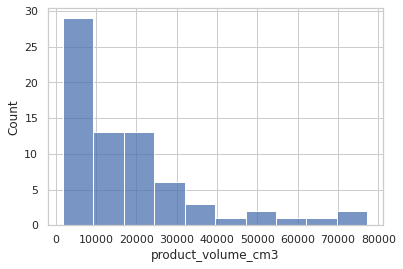

In [27]:
sns.histplot(data = product_cat, x = "product_volume_cm3")

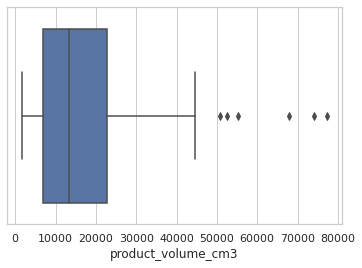

In [28]:
sns.boxplot(data = product_cat, x = "product_volume_cm3")

In [29]:
round(product_cat[interesting_features].describe(),2)

,wait_time,n_orders,product_name_length,price,product_photos_qty,sales,product_weight_g,quantity,product_volume_cm3
count,71.00,71.00,71.00,71.00,71.00,71.00,71.00,71.00,71.00
mean,11.89,3.05,48.09,165.88,2.24,232729.10,2739.05,1548.73,18512.60
std,2.16,1.79,3.46,153.42,0.63,394763.22,2998.09,2584.65,16927.74
min,5.36,1.00,39.35,35.69,1.10,283.29,237.07,2.00,1798.46
25%,10.92,2.07,46.13,86.62,1.98,10810.43,795.33,92.50,6870.73
50%,11.81,2.54,48.02,132.37,2.22,48949.53,1714.65,277.00,13462.49
75%,13.17,3.73,50.90,181.88,2.53,240861.49,3234.60,1805.00,22810.85
max,18.33,12.00,55.72,1183.21,5.18,1981003.59,13190.00,11046.00,77244.30


In [30]:
# product_volume_cm3
q1 = product_cat["product_volume_cm3"].describe()["25%"]
q3 = product_cat["product_volume_cm3"].describe()["75%"]
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
upper_bound

46721.03383124129

In [31]:
import plotly.express as px

fig = px.scatter(
    product_cat[product_cat['product_volume_cm3'] > upper_bound].reset_index(),
    x="wait_time",
    y="product_volume_cm3",
    size="sales",
    hover_name="category",
    color="review_score",
    size_max=40,
)
fig.show()

### (3.4) Causal inference

☝️ It seems that `large products` like `office_furniture` and `furniture_mattress_and_upholstery`, which happen to take longer to deliver, are performing worse than other products.

🤔 Are consumers disappointed about these products or by the slow delivery time ❓ 

👉 Run an OLS to model `review_score` :
* to isolate the real contribution of each product category on customer satisfaction, 
* by holding `wait_time` constant.

<u>**Questions**</u>:

1️⃣ Which dataset should you use for this regression: `product_cat` or the entire `products` training dataset ?

2️⃣ Which independent variables / features should you use ?

3️⃣ 🕵🏻 Investigate the results: which product categories correlate with a higher `review_score` (holding `wait_time` constant) ?

🎁 Feel free to use `return_significative_coef(model)` function coded for you in `olist/utils.py`

In [32]:
# What are the numerical columns of the products dataset ? 
numerical_columns = products.select_dtypes(exclude = ["object"]).columns

# Standardize your dataset before running the OLS:
products_std = products.copy()
for f in numerical_columns:
    mu = products[f].mean()
    sigma = products[f].std()
    products_std[f] = products[f].map(lambda x: (x - mu) / sigma)

products_std.head()

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,sales,product_volume_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,-0.836833,-0.763242,-0.684384,-0.479703,-0.876858,-0.507025,-0.762147,perfumery,-1.101806,-0.549566,-0.414537,0.974332,0.775088,-0.226987,-0.231049,-0.293878,-0.530169
1,6a2fb4dd53d2cdb88e0432f1284a004c,-0.934841,-0.670344,-0.109395,-0.438617,-0.225953,-0.874949,-0.263969,perfumery,-0.223766,-0.524959,-0.414537,-0.214228,-0.531302,-0.122772,-0.138354,-0.277420,-0.512988
2,0d009643171aee696f4733340bc2fdd0,0.339265,-0.978953,-0.684384,-0.433452,-0.580992,-0.065516,-0.430028,perfumery,0.218835,0.743302,0.331102,-0.451940,-0.357116,0.710949,0.695903,2.273700,-0.387941
3,b1eae565a61935e0011ee7682fef9dc9,0.045241,-0.490847,-0.109395,-0.469843,-0.817684,-0.286271,-0.513058,perfumery,1.100232,1.048417,-0.414537,-1.402789,-1.837691,-0.226987,-0.231049,-0.014191,-0.473509
4,8da90b37f0fb171b4877c124f965b1f6,0.731297,-0.060999,0.465594,-0.444017,-0.758511,-0.286271,-0.679117,perfumery,-0.382166,-0.027887,-0.414537,0.974332,0.775088,-0.226987,-0.231049,-0.202571,-0.482735


In [33]:
# Actually, we did not have to standardize this time...
# ...as we are involving only the category of the products 
# ... and a single numerical feature: the wait_time

model = smf.ols(formula='review_score ~ C(category) + wait_time', data=products).fit()

In [34]:
print(model.rsquared)

0.09408251104678578


In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     45.94
Date:                Wed, 24 Aug 2022   Prob (F-statistic):               0.00
Time:                        07:12:56   Log-Likelihood:                -47463.
No. Observations:               31482   AIC:                         9.507e+04
Df Residuals:                   31410   BIC:                         9.567e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  4.3845      0.130     33.694      0.000       4.129       4.640
C(category)[T.air_conditioning]                            0.0615      0.164      0.375      0.707      -0.260       0.383
C(category)[T.art]                                         0.3383      0.201      1.685      0.092      -0.055       0.732
C(category)[T.arts_and_craftmanship]                       0.1858      0.283      0.658      0.511      -0.368       0.740
C(category)[T.audio]                                      -0.0994      0.194     -0.513      0.608      -0.479       0.280
C(category)[T.auto]                                        0.2068      0.132      1.563      0.118      -0.052       0.466
C(category)[T.baby]                                        0.1529      0.135      1.133      0.257      -0.112       0.417
C(category)[T.bed_bath_table]                              0.0124      0.131      0.094      0.925      -0.245       0.270
C(category)[T.books_general_interest]                      0.5706      0.150      3.792      0.000       0.276       0.865
C(category)[T.books_imported]                              0.3296      0.238      1.383      0.167      -0.137       0.797
C(category)[T.books_technical]                             0.5106      0.163      3.127      0.002       0.190       0.831
C(category)[T.cds_dvds_musicals]                           0.7153      1.102      0.649      0.516      -1.444       2.875
C(category)[T.christmas_supplies]                          0.3647      0.190      1.918      0.055      -0.008       0.737
C(category)[T.cine_photo]                                  0.0716      0.251      0.285      0.775      -0.420       0.563
C(category)[T.computers]                                   0.2701      0.241      1.120      0.263      -0.203       0.743
C(category)[T.computers_accessories]                       0.1364      0.133      1.028      0.304      -0.124       0.396
C(category)[T.consoles_games]                              0.2972      0.144      2.058      0.040       0.014       0.580
C(category)[T.construction_tools_construction]             0.1792      0.141      1.270      0.204      -0.097       0.456
C(category)[T.construction_tools_lights]                   0.0319      0.181      0.176      0.860      -0.322       0.386
C(category)[T.construction_tools_safety]                   0.0525      0.175      0.301      0.764      -0.290       0.395
C(category)[T.cool_stuff]                                  0.3096      0.136      2.281      0.023       0.044       0.576
C(category)[T.costruction_tools_garden]                    0.1764      0.175      1.005      0.315      -0.167       0.520
C(catego

In [36]:
# What are the top five coefficients with a p-value < 0.05 ?

from olist.utils import return_significative_coef
return_significative_coef(model)[1:6]

,variable,p_value,coef
8,C(category)[T.books_general_interest],0.000150,0.570564
31,C(category)[T.fashion_shoes],0.000808,0.518896
10,C(category)[T.books_technical],0.001770,0.510570
37,C(category)[T.food_drink],0.006054,0.467034
53,C(category)[T.luggage_accessories],0.005320,0.397271


☝️ Furnitures are not in the list of significant coefficients! 

😉 The low review_score for furnitures may result from the delivery rather than the product itself! 

💡On the contrary, books are regularly driving higher reviews, even after accounting for generally quicker delivery time. 

---